# Project: Predicting the status of Covid-19 patients using the Random Forests Approach

## 1. Introduction: Corinavirus (Covid-19)

Coronavirus disease (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus.

Most people infected with the virus will experience mild to moderate respiratory illness and recover without requiring special treatment. However, some will become seriously ill and require medical attention. Older people and those with underlying medical conditions like cardiovascular disease, diabetes, chronic respiratory disease, or cancer are more likely to develop serious illness. Anyone can get sick with COVID-19 and become seriously ill or die at any age. 

The best way to prevent and slow down transmission is to be well informed about the disease and how the virus spreads. Protect yourself and others from infection by staying at least 1 metre apart from others, wearing a properly fitted mask, and washing your hands or using an alcohol-based rub frequently. Get vaccinated when it’s your turn and follow local guidance.

The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe. These particles range from larger respiratory droplets to smaller aerosols. It is important to practice respiratory etiquette, for example by coughing into a flexed elbow, and to stay home and self-isolate until you recover if you feel unwell.

Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country.

## 2. Objective

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

## 3.  Before we dive into that project, here's a quick primer on Random Forest.

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. 


## 4. Dataset Loading

First, let's load the needed packages and modules into Python. Next, let's load the data into a pandas dataframe for ease of use.

In [65]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [66]:
os.chdir(r"C:\\Users\\moham\\OneDrive\\Desktop\\Other\\Bootcamp\\ML\\1593492590_RandomForest_Covid_Case_Study_06302020\\RandomForest Covid Case Study_06302020")

In [67]:
# List files/folders in the cd:
os.listdir()

['RandomForest_casestudy_covid19.ipynb',
 'SouthKoreacoronavirusdataset',
 'SouthKoreacoronavirusdataset-20200630T044816Z-001.zip']

In [68]:
#Unzipping the file

from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = 'SouthKoreacoronavirusdataset-20200630T044816Z-001.zip'
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

File Name                                             Modified             Size
SouthKoreacoronavirusdataset/PatientInfo.csv   2020-03-30 01:35:28       220884
Extracting all the files now...
Done!


In [69]:
# Now let's read the PatientInfo.csv:
df = pd.read_csv('SouthKoreacoronavirusdataset/PatientInfo.csv')
pd.options.display.max_columns = None
df.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001        2.00    male     1964.00  50s   Korea    Seoul   
1  1000000002        5.00    male     1987.00  30s   Korea    Seoul   
2  1000000003        6.00    male     1964.00  50s   Korea    Seoul   
3  1000000004        7.00    male     1991.00  20s   Korea    Seoul   
4  1000000005        9.00  female     1992.00  20s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow             1.00           NaN   
1  Jungnang-gu     NaN       overseas inflow             1.00           NaN   
2    Jongno-gu     NaN  contact with patient             2.00 2002000001.00   
3      Mapo-gu     NaN       overseas inflow             1.00           NaN   
4  Seongbuk-gu     NaN  contact with patient             2.00 1000000002.00   

   contact_number symptom_onset_date confirmed_date released_date  \
0           75.00         2020-01-22     2020-01-23    2020-02-05   
1           31.00                NaN     2020-01-30    2020-03-02   
2           17.00                NaN     2020-01-30    2020-02-19   
3            9.00         2020-01-26     2020-01-30    2020-02-15   
4            2.00                NaN     2020-01-31    2020-02-24   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released  
3           NaN  released  
4           NaN  released

In [70]:
df.shape

(2218, 18)

## 5. Data Wrangling and Transformation

In [71]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

VarName  NullCount
0              disease       2199
1        deceased_date       2186
2      infection_order       2176
3   symptom_onset_date       2025
4        released_date       1995
5       contact_number       1807
6          infected_by       1749
7       infection_case       1055
8           global_num        904
9           birth_year        454
10                 age        261
11                 sex        145
12      confirmed_date        141
13               state         88
14                city         65

In [72]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [73]:
# let's check how much missing data we have in birth_year:
birth_year = pd.concat([df[['birth_year']].isnull().sum(), 100 * df[['birth_year']].isnull().mean()], axis=1)
birth_year.columns=['count', '%']
birth_year

count     %
birth_year    454 20.47

In [74]:
# Ok, now let's explore the data further:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df[df['birth_year'].isnull()]

patient_id  global_num     sex  birth_year  age country  \
446   1300000001       16.00  female         NaN  40s   Korea   
447   1300000002       18.00  female         NaN  20s   Korea   
448   1300000003      126.00    male         NaN  30s   Korea   
449   1300000004      164.00    male         NaN  30s   Korea   
450   1300000005      210.00    male         NaN  30s   Korea   
451   1300000006      239.00    male         NaN  30s   Korea   
452   1300000007      489.00    male         NaN  30s   Korea   
453   1300000008      589.00  female         NaN  30s   Korea   
454   1300000009      611.00  female         NaN  30s   Korea   
455   1300000010     4388.00  female         NaN  40s   Korea   
456   1300000011     4257.00    male         NaN  20s   Korea   
457   1300000012     5141.00  female         NaN  80s   Korea   
458   1300000013     5031.00    male         NaN  50s   Korea   
459   1300000014     7268.00    male         NaN  20s   Korea   
460   1300000015     7285.00  female         NaN  20s   Korea   
461   1300000016     8141.00  female         NaN  40s   Korea   
462   1300000017     8395.00  female         NaN  50s   Korea   
463   1300000018         NaN    male         NaN  60s   Korea   
496   1500000001      241.00  female         NaN  20s   Korea   
497   1500000002      372.00  female         NaN  60s   Korea   
498   1500000003      573.00    male         NaN  60s   Korea   
499   1500000004     1256.00  female         NaN  40s   Korea   
500   1500000005     1252.00    male         NaN  30s   Korea   
501   1500000006     1257.00  female         NaN  40s   Korea   
502   1500000007     1856.00    male         NaN  30s   Korea   
503   1500000008     1568.00    male         NaN  30s   Korea   
504   1500000009     1569.00    male         NaN  70s   Korea   
505   1500000010     1788.00    male         NaN  30s   Korea   
506   1500000011     1913.00    male         NaN  40s   Korea   
507   1500000012     2020.00  female         NaN  40s   Korea   
508   1500000013     2025.00  female         NaN  20s   Korea   
509   1500000014     3797.00    male         NaN  20s   Korea   
510   1500000015     4996.00    male         NaN  20s   Korea   
511   1500000016     5764.00    male         NaN  50s   Korea   
512   1500000017     6078.00  female         NaN  40s   Korea   
513   1500000018     6018.00    male         NaN  20s   Korea   
514   1500000019     7820.00  female         NaN  70s   Korea   
515   1500000020     7867.00    male         NaN  80s   Korea   
516   1500000021     7945.00  female         NaN  50s   Korea   
517   1500000022     7974.00  female         NaN  20s   Korea   
549   1700000002         NaN  female         NaN  40s   Korea   
550   1700000003         NaN  female         NaN  20s   Korea   
551   1700000004         NaN  female         NaN  50s   Korea   
552   1700000005         NaN  female         NaN  40s   Korea   
553   1700000006         NaN  female         NaN  40s   Korea   
554   1700000007         NaN  female         NaN  40s   Korea   
555   1700000008         NaN  female         NaN  10s   Korea   
556   1700000009         NaN    male         NaN  50s   Korea   
557   1700000010         NaN    male         NaN  50s   Korea   
558   1700000011         NaN  female         NaN  10s   Korea   
559   1700000012         NaN  female         NaN  40s   Korea   
560   1700000013         NaN  female         NaN  40s   Korea   
561   1700000014         NaN    male         NaN  40s   Korea   
562   1700000015         NaN    male         NaN  50s   Korea   
563   1700000016         NaN    male         NaN  50s   Korea   
564   1700000017         NaN  female         NaN  40s   Korea   
565   1700000018         NaN  female         NaN  30s   Korea   
566   1700000019         NaN    male         NaN  40s   Korea   
567   1700000020         NaN    male         NaN  50s   Korea   
568   1700000021         NaN    male         NaN  50s   Korea   
569   1700000022         NaN    male     

In [75]:
# Some more information on birth_year: Out of the rows missing the birth year, is there data on age instead?
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df[(df['birth_year'].isnull()) & (df['age'].notna())].count()

patient_id            303
global_num            102
sex                   301
birth_year              0
age                   303
country               303
province              303
city                  285
disease                 1
infection_case        158
infection_order         0
infected_by            50
contact_number         84
symptom_onset_date     31
confirmed_date        303
released_date          28
deceased_date           2
state                 303
dtype: int64

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [77]:
# Some of the data in the "age" column has an "s" that will trigger an error when attempting to convert the data to a float type.

df['age'] = df['age'].str.strip('s')

# let's convert data type of 'age' from object to float so we can impute the data at birth_year:
df['age'] = df['age'].astype('float64')
df.loc[df['birth_year'].isnull(), 'birth_year'] = 2021 - df['age'] # using Year 2021 for dataset time

# let's check how much missing data we still have in birth_year:
birth_year_post = pd.concat([df[['birth_year']].isnull().sum(), 100 * df[['birth_year']].isnull().mean()], axis=1)
birth_year_post.columns=['count', '%']
birth_year_post

count    %
birth_year    151 6.81

#### We managed to impute the missing data of the original 'birth_year' variable with the "age" information instead and we saved 14% of the missing data, now let's check if we still have any other similar issues.

In [78]:
# Let's look at 'deceased_date' & 'state':
df[(df['deceased_date'].notna()) & (df['state'] == 'released')]

patient_id  global_num     sex  birth_year   age country province  \
109  1000000110     6781.00    male     1964.00 50.00   Korea    Seoul   
187  1000000188     7561.00  female     1994.00 20.00   Korea    Seoul   

              city disease        infection_case  infection_order  \
109     Gangnam-gu     NaN  contact with patient              NaN   
187  Dongdaemun-gu     NaN  contact with patient              NaN   

      infected_by  contact_number symptom_onset_date confirmed_date  \
109           NaN             NaN                NaN     2020-03-07   
187 1000000127.00             NaN                NaN     2020-03-10   

    released_date deceased_date     state  
109           NaN    2020-03-19  released  
187           NaN    2020-03-19  released

In [79]:
# let fix the wrong values:
df.at[109,'state'] = 'deceased'
df.at[187,'state'] = 'deceased'

In [80]:
# let's check the "disease" data:
disease = pd.concat([df[['disease']].isnull().sum(), 100 * df[['disease']].isnull().mean()], axis=1)
disease.columns=['count', '%']
disease

count     %
disease   2199 99.14

In [81]:
# let's check the "state" data:
state = pd.concat([df[['state']].isnull().sum(), 100 * df[['state']].isnull().mean()], axis=1)
state.columns=['count', '%']
state

count    %
state     88 3.97

In [82]:
df.head(20)

patient_id  global_num     sex  birth_year   age country province  \
0   1000000001        2.00    male     1964.00 50.00   Korea    Seoul   
1   1000000002        5.00    male     1987.00 30.00   Korea    Seoul   
2   1000000003        6.00    male     1964.00 50.00   Korea    Seoul   
3   1000000004        7.00    male     1991.00 20.00   Korea    Seoul   
4   1000000005        9.00  female     1992.00 20.00   Korea    Seoul   
5   1000000006       10.00  female     1966.00 50.00   Korea    Seoul   
6   1000000007       11.00    male     1995.00 20.00   Korea    Seoul   
7   1000000008       13.00    male     1992.00 20.00   Korea    Seoul   
8   1000000009       19.00    male     1983.00 30.00   Korea    Seoul   
9   1000000010       21.00  female     1960.00 60.00   Korea    Seoul   
10  1000000011       23.00  female     1962.00 50.00   China    Seoul   
11  1000000012       24.00    male     1992.00 20.00   Korea    Seoul   
12  1000000013       29.00    male     1938.00 80.00   Korea    Seoul   
13  1000000014       30.00  female     1952.00 60.00   Korea    Seoul   
14  1000000015       40.00    male     1943.00 70.00   Korea    Seoul   
15  1000000016       56.00    male     1945.00 70.00   Korea    Seoul   
16  1000000017       83.00    male     1944.00 70.00   Korea    Seoul   
17  1000000018      111.00    male     2000.00 20.00   Korea    Seoul   
18  1000000019      112.00  female     1941.00 70.00   Korea    Seoul   
19  1000000020      121.00  female     1944.00 70.00   Korea    Seoul   

            city disease        infection_case  infection_order   infected_by  \
0     Gangseo-gu     NaN       overseas inflow             1.00           NaN   
1    Jungnang-gu     NaN       overseas inflow             1.00           NaN   
2      Jongno-gu     NaN  contact with patient             2.00 2002000001.00   
3        Mapo-gu     NaN       overseas inflow             1.00           NaN   
4    Seongbuk-gu     NaN  contact with patient             2.00 1000000002.00   
5      Jongno-gu     NaN  contact with patient             3.00 1000000003.00   
6      Jongno-gu     NaN  contact with patient             3.00 1000000003.00   
7            etc     NaN       overseas inflow             1.00           NaN   
8      Songpa-gu     NaN       overseas inflow             2.00           NaN   
9    Seongbuk-gu     NaN  contact with patient             3.00 1000000003.00   
10  Seodaemun-gu     NaN       overseas inflow             1.00           NaN   
11           etc     NaN       overseas inflow             1.00           NaN   
12     Jongno-gu     NaN  contact with patient             4.00 1000000017.00   
13     Jongno-gu     NaN  contact with patient             5.00 1000000013.00   
14  Seongdong-gu     NaN      Seongdong-gu APT              NaN           NaN   
15     Jongno-gu     NaN  contact with patient             4.00 1000000017.00   
16     Jongno-gu     NaN  contact with patient             3.00 1000000003.00   
17           etc     NaN                   etc              NaN           NaN   
18     Jongno-gu     NaN  contact with patient             5.00 1000000021.00   
19  Seongdong-gu     NaN      Seongdong-gu APT              NaN 1000000015.00   

    contact_number symptom_onset_date confirmed_date released_date  \
0            75.00         2020-01-22     2020-01-23    2020-02-05   
1            31.00                NaN     2020-01-30    2020-03-02   
2            17.00                NaN     2020-01-30    2020-02-19   
3             9.00         2020-01-26     2020-01-30    2020-02-15   
4             2.00                NaN     2020-01-31    2020-02-24   
5            43.00                NaN     2020-01-31    2020-02-19   
6             0.00                NaN     2020-01-31    2020-02-10   
7             0.00                NaN     2020-02-02    2020-02-24   
8            68.00                NaN     2020-02-05    2020-02-21   
9             6.00                NaN     2020-02-05    2020-02-29  

In [83]:
df.loc[df.state == 'released', 'disease'] = False
df.loc[df.state == 'isolated', 'disease'] = False
df.loc[df.state == 'deceased', 'disease'] = True

df

patient_id  global_num     sex  birth_year    age   country  \
0     1000000001        2.00    male     1964.00  50.00     Korea   
1     1000000002        5.00    male     1987.00  30.00     Korea   
2     1000000003        6.00    male     1964.00  50.00     Korea   
3     1000000004        7.00    male     1991.00  20.00     Korea   
4     1000000005        9.00  female     1992.00  20.00     Korea   
5     1000000006       10.00  female     1966.00  50.00     Korea   
6     1000000007       11.00    male     1995.00  20.00     Korea   
7     1000000008       13.00    male     1992.00  20.00     Korea   
8     1000000009       19.00    male     1983.00  30.00     Korea   
9     1000000010       21.00  female     1960.00  60.00     Korea   
10    1000000011       23.00  female     1962.00  50.00     China   
11    1000000012       24.00    male     1992.00  20.00     Korea   
12    1000000013       29.00    male     1938.00  80.00     Korea   
13    1000000014       30.00  female     1952.00  60.00     Korea   
14    1000000015       40.00    male     1943.00  70.00     Korea   
15    1000000016       56.00    male     1945.00  70.00     Korea   
16    1000000017       83.00    male     1944.00  70.00     Korea   
17    1000000018      111.00    male     2000.00  20.00     Korea   
18    1000000019      112.00  female     1941.00  70.00     Korea   
19    1000000020      121.00  female     1944.00  70.00     Korea   
20    1000000021      136.00    male     1936.00  80.00     Korea   
21    1000000022      161.00    male     1985.00  30.00     Korea   
22    1000000023      188.00    male     1961.00  50.00     Korea   
23    1000000024      348.00    male     1980.00  40.00     Korea   
24    1000000025      365.00    male     1958.00  60.00     Korea   
25    1000000026      420.00    male     1986.00  30.00     Korea   
26    1000000027      593.00    male     1968.00  50.00     Korea   
27    1000000028      627.00  female     1950.00  70.00     Korea   
28    1000000029      754.00  female     1995.00  20.00     Korea   
29    1000000030      755.00    male     1954.00  60.00     China   
30    1000000031      780.00    male     1965.00  50.00     Korea   
31    1000000032      787.00    male     1962.00  50.00     Korea   
32    1000000033      794.00  female     1970.00  50.00     Korea   
33    1000000034      797.00    male     2000.00  20.00     Korea   
34    1000000035      847.00    male     1984.00  30.00     Korea   
35    1000000036      870.00  female     1963.00  50.00     Korea   
36    1000000037      887.00  female     1976.00  40.00     Korea   
37    1000000038      907.00    male     1953.00  60.00     Korea   
38    1000000039      924.00  female     1945.00  70.00     China   
39    1000000040      935.00  female     1960.00  60.00     Korea   
40    1000000041      938.00    male     1968.00  50.00     Korea   
41    1000000042      996.00    male     1977.00  40.00     Korea   
42    1000000043     1022.00  female     1995.00  20.00     Korea   
43    1000000044     1027.00    male     1958.00  60.00     Korea   
44    1000000045     1118.00    male     1979.00  40.00     Korea   
45    1000000046     1246.00  female     1999.00  20.00     Korea   
46    1000000047     1247.00    male     1993.00  20.00     Korea   
47    1000000048     1253.00  female     1995.00  20.00     Korea   
48    1000000049     1254.00    male     1956.00  60.00     Korea   
49    1000000050     1295.00    male     1994.00  20.00     Korea   
50    1000000051     1370.00  female     1992.00  20.00     Korea   
51    1000000052     1378.00    male     1984.00  30.00     Korea   
52    1000000053     1531.00  female     1973.00  40.00     Korea   
53    1000000054     1532.00  female     1937.00  80.00     Korea   
54    1000000055     1567.00  female     1993.00  20.00     Korea   
55    1000000056     1611.00    male     1962.00  50.00     Korea   
56    1000000057     1675.00  female     1946.00  70.00     Korea   
57  

In [84]:
# let's now check how much missing data we have in "disease" after inferring them from "state":
disease_post = pd.concat([df[['disease']].isnull().sum(), 100 * df[['disease']].isnull().mean()], axis=1)
disease_post.columns=['count', '%']
disease_post

count    %
disease     88 3.97

### Handle Missing Values

- Fill the 'disease' missing values with 0 and remap the True values to 1.
    
- Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'

- Fill the rest of the missing values with any method

In [85]:
# let's check if we have any NANs:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          2067 non-null   float64
 4   age                 1957 non-null   float64
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             2130 non-null   object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [86]:
# Print the number of missing values by column:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count     %
deceased_date        2186 98.56
infection_order      2176 98.11
symptom_onset_date   2025 91.30
released_date        1995 89.95
contact_number       1807 81.47
infected_by          1749 78.85
infection_case       1055 47.57
global_num            904 40.76
age                   261 11.77
birth_year            151  6.81
sex                   145  6.54
confirmed_date        141  6.36
state                  88  3.97
disease                88  3.97
city                   65  2.93
province                0  0.00
country                 0  0.00
patient_id              0  0.00

In [87]:
# Let's explore unique values of 'disease'
df['disease'].unique()

array([False, True, nan], dtype=object)

In [88]:
#Fill the 'disease' missing values with: False: 0, NaN: 0 and True: 1
df = df.fillna({'disease': 0})

# and let's remap the True values to 1:
df['disease'] = df['disease'].replace(True, 1)
df['disease'] = df['disease'].replace(False, 0)
df['disease'].unique()

array([0, 1], dtype=int64)

In [89]:
df['disease'].value_counts()

0    2184
1      34
Name: disease, dtype: int64

In [90]:
df[['global_num','birth_year','infection_order','infected_by','contact_number' ]].describe()

global_num  birth_year  infection_order   infected_by  contact_number
count     1314.00     2067.00            42.00        469.00          411.00
mean      4664.82     1975.94             2.29 2600788987.59           24.13
std       2874.04       19.48             1.25 1570638245.04           91.09
min          1.00     1916.00             1.00 1000000002.00            0.00
25%       1908.50     1962.00             1.25 1200000031.00            2.00
50%       5210.50     1976.00             2.00 2000000142.00            5.00
75%       7481.50     1993.00             3.00 4100000008.00           16.00
max       8717.00     2021.00             6.00 6113000028.00         1160.00

### Let's fill 'global_num','birth_year','infection_order','infected_by','contact_number' missing values with mean() or median()

In [91]:
# Fill null values in the following columns with its mean:
# 'global_num','birth_year','infection_order','infected_by', 'contact_number'
cols = ['global_num','birth_year','infection_order','infected_by', 'contact_number']

imp_mean = IterativeImputer(missing_values = np.nan, initial_strategy = 'mean')
imp_mean.fit((df[cols]))
df[cols]=imp_mean.transform(df[cols])

In [92]:
# Now let's confirm there are no NANs at: 'global_num','birth_year','infection_order','infected_by'and 'contact_number':
cols = ['global_num','birth_year','infection_order','infected_by', 'contact_number']

missing = pd.concat([df[cols].isnull().sum(), 100 * df[cols].isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
global_num           0 0.00
birth_year           0 0.00
infection_order      0 0.00
infected_by          0 0.00
contact_number       0 0.00

In [93]:
# Let's create a new column named 'n_age' which is the calculated age based on the 'birth_year' column
df['n_age'] = 2021 - df['birth_year']
df.head()

patient_id  global_num     sex  birth_year   age country province  \
0  1000000001        2.00    male     1964.00 50.00   Korea    Seoul   
1  1000000002        5.00    male     1987.00 30.00   Korea    Seoul   
2  1000000003        6.00    male     1964.00 50.00   Korea    Seoul   
3  1000000004        7.00    male     1991.00 20.00   Korea    Seoul   
4  1000000005        9.00  female     1992.00 20.00   Korea    Seoul   

          city  disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu        0       overseas inflow             1.00 2600788988.72   
1  Jungnang-gu        0       overseas inflow             1.00 2600788988.72   
2    Jongno-gu        0  contact with patient             2.00 2002000001.00   
3      Mapo-gu        0       overseas inflow             1.00 2600788988.72   
4  Seongbuk-gu        0  contact with patient             2.00 1000000002.00   

   contact_number symptom_onset_date confirmed_date released_date  \
0           75.00         2020-01-22     2020-01-23    2020-02-05   
1           31.00                NaN     2020-01-30    2020-03-02   
2           17.00                NaN     2020-01-30    2020-02-19   
3            9.00         2020-01-26     2020-01-30    2020-02-15   
4            2.00                NaN     2020-01-31    2020-02-24   

  deceased_date     state  n_age  
0           NaN  released  57.00  
1           NaN  released  34.00  
2           NaN  released  57.00  
3           NaN  released  30.00  
4           NaN  released  29.00

In [94]:
# let's drop the following columns:
# 'symptom_onset_date','confirmed_date','released_date','deceased_date'
# please note we're removing 'birth_year' because we already have 'n_age'
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date', 'birth_year'],axis =1) 
df.head()

patient_id  global_num     sex   age country province         city  \
0  1000000001        2.00    male 50.00   Korea    Seoul   Gangseo-gu   
1  1000000002        5.00    male 30.00   Korea    Seoul  Jungnang-gu   
2  1000000003        6.00    male 50.00   Korea    Seoul    Jongno-gu   
3  1000000004        7.00    male 20.00   Korea    Seoul      Mapo-gu   
4  1000000005        9.00  female 20.00   Korea    Seoul  Seongbuk-gu   

   disease        infection_case  infection_order   infected_by  \
0        0       overseas inflow             1.00 2600788988.72   
1        0       overseas inflow             1.00 2600788988.72   
2        0  contact with patient             2.00 2002000001.00   
3        0       overseas inflow             1.00 2600788988.72   
4        0  contact with patient             2.00 1000000002.00   

   contact_number     state  n_age  
0           75.00  released  57.00  
1           31.00  released  34.00  
2           17.00  released  57.00  
3            9.00  released  30.00  
4            2.00  released  29.00

### Visualization

Text(0.5, 1.0, 'COVID-19 Correlation')

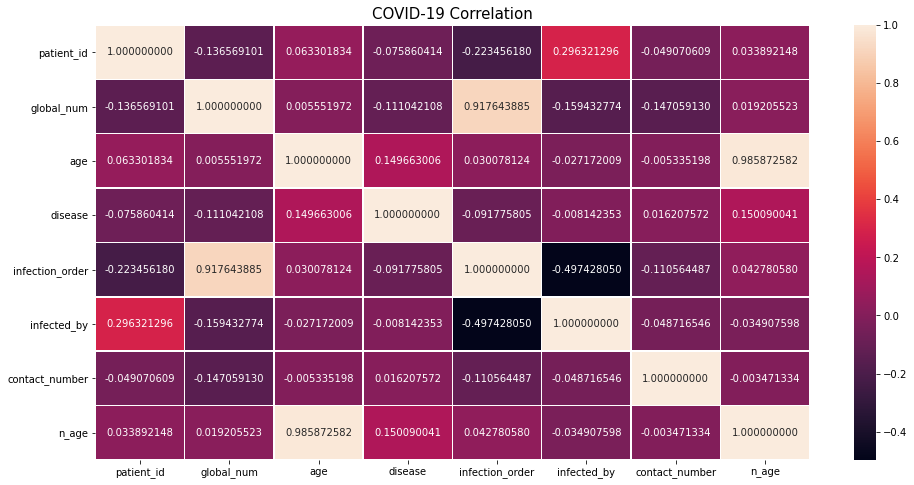

In [95]:
# Make a heatmap of the data 
plt.figure(figsize=(16,8)) # ensure that the Matplotlib plot is big enough
sns.heatmap(df.corr(), linewidths=.4, annot=True, fmt=".9f")
plt.title('COVID-19 Correlation', fontsize=15)

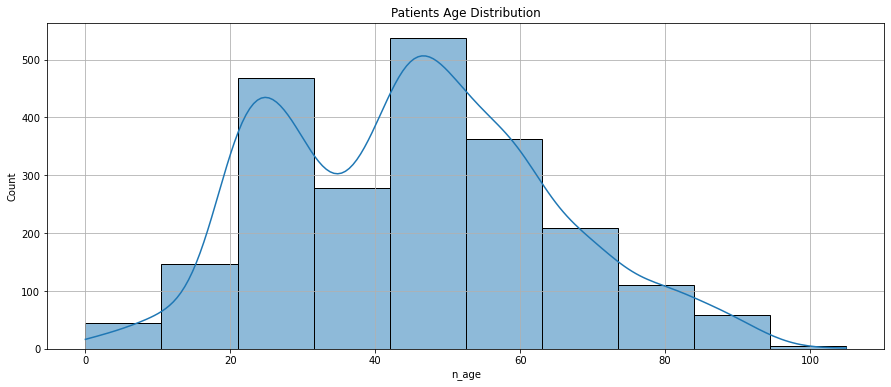

In [96]:
# Making a histogram of the n_age variable.
f, ax = plt.subplots(figsize = (15,6))
ax = sns.histplot(x=df['n_age'], kde=True, bins=10)
ax.set_title('Patients Age Distribution')
plt.grid(True)

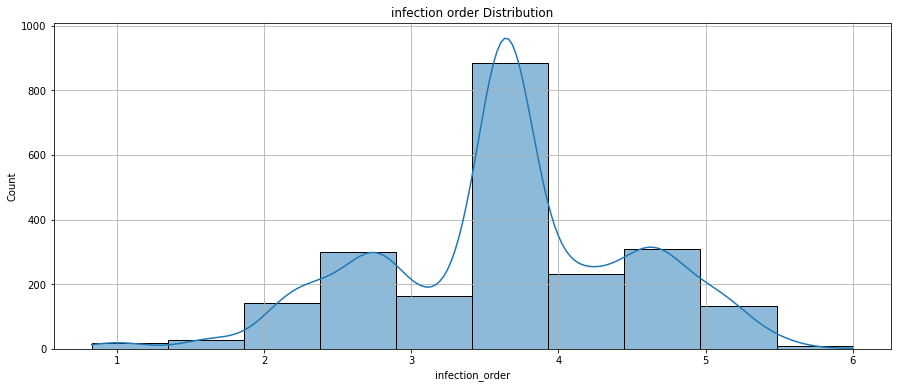

In [97]:
# Making a histogram of the infection_order variable.
f, ax = plt.subplots(figsize = (15,6))
ax = sns.histplot(x=df['infection_order'], kde=True, bins=10)
ax.set_title('infection order Distribution')
plt.grid(True)

In [98]:
#Checking for duplicated rows
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

Empty DataFrame
Columns: [patient_id, global_num, sex, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, state, n_age]
Index: []

Reviewing the count of unique values by column.

In [99]:
print(df.nunique())

patient_id         2218
global_num         1700
sex                   2
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order    1672
infected_by        1348
contact_number     1381
state                 3
n_age               102
dtype: int64


Reviewing the percent of unique values by column.

In [100]:
print(df.nunique()/df.shape[0])

patient_id        1.00
global_num        0.77
sex               0.00
age               0.00
country           0.00
province          0.01
city              0.06
disease           0.00
infection_case    0.01
infection_order   0.75
infected_by       0.61
contact_number    0.62
state             0.00
n_age             0.05
dtype: float64


Printing the categorical columns and their associated levels.

In [101]:
# let's convert back 'age' from floar to str:
df['age'] = df['age'].astype('str')

In [102]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

VarName  LevelsCount
0             sex            2
1             age           12
2         country            4
3        province           17
4            city          134
5  infection_case           16
6           state            3

Reviewing the range of values per column.

In [103]:
pd.set_option('float_format', '{:.2f}'.format)
df.describe()

patient_id  global_num  disease  infection_order   infected_by  \
count       2218.00     2218.00  2218.00          2218.00       2218.00   
mean  4014678094.55     4585.63     0.02             3.64 2600788987.64   
std   2192418596.14     2230.94     0.12             0.85  721632772.67   
min   1000000001.00        1.00     0.00             0.83 1000000002.00   
25%   1700000007.25     3846.69     0.00             3.10 2600788987.01   
50%   6001000034.50     4585.63     0.00             3.64 2600788987.64   
75%   6004000027.75     5900.25     0.00             4.19 2600788987.86   
max   7000000004.00     8717.00     1.00             6.00 6113000028.00   

       contact_number   n_age  
count         2218.00 2218.00  
mean            22.00   45.06  
std             39.51   18.81  
min              0.00    0.00  
25%             14.84   29.00  
50%             22.00   45.06  
75%             22.14   58.00  
max           1160.00  105.00

Now let's check which variables still have NANs

In [104]:
# let's first confirm there are no NANs at: 'global_num','birth_year','infection_order','infected_by'and 'contact_number':
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count     %
infection_case    1055 47.57
sex                145  6.54
state               88  3.97
city                65  2.93
patient_id           0  0.00
global_num           0  0.00
age                  0  0.00
country              0  0.00
province             0  0.00
disease              0  0.00
infection_order      0  0.00
infected_by          0  0.00
contact_number       0  0.00
n_age                0  0.00

#### Dealing with Missing Categorical Data Using KNN imputer "fancyimpute"

In [105]:
cat_var = ['infection_case', 'sex', 'state', 'city']
df[cat_var].dtypes

infection_case    object
sex               object
state             object
city              object
dtype: object

In [106]:
# Let's explore our categorical variables count so we can have an idea of the best way to handle the missing data:
print("infection_case count: ")
print(df['infection_case'].value_counts())
print('===============================================')
print("state count: ")
print(df['state'].value_counts())
print('===============================================')
print("sex count: ")
print(df['sex'].value_counts())
print('===============================================')
print("city count: ")
print(df['city'].value_counts())
print('===============================================')

infection_case count: 
contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
Pilgrimage to Israel                  1
River of Grace Community Church       1
Name: infection_case, dtype: int64
state count: 
isolated    1791
released     305
deceased      34
Name: state, dtype: int64
sex count: 
female    1171
male       902
Name: sex, dtype: int64
city count: 
Gyeongsan-si       535
Cheonan-si          98
Seongnam-si         89
Bonghwa-gun         60
Gumi-si             59
Chilgok-gun      

**We have many methods we can explore to use in order to handle missing data such as the above variables:**

- Frequent Categorical Imputation: By replacing NaN values with the most frequent occurred category in the variable/column. Unfortunately this method won't be applicable in our case because as shown above we have a very high count in one value compared to others in all the variables, so using this method will bias the prediction and distorts the relation of the most frequent labels.

- By Creating a new category for NaN values at random . Not a good option since "infection_case" has almost 47% of the data that are missing.


- By replacing NaN categories with most occurred values, and adding a new feature to introduce some weight/importance to non-imputed and imputed observations. This is not a good option because this method will create additional columns and there will be a risk of experiencing a Curse of Dimensionality and/or wrongly misunderstanding the data.


- KNN imputer "fancyimpute" for Categorical features: We are going to build a process that will handle all categorical variables in the dataset. The process will be outlined step by step as shown below:


*KNN imputer "fancyimpute" for Categorical features*:

- fancyimpute is a wonderful way to apply an alternate imputation method to our data set. There are several methods that fancyimpute can perform ([More information here](https://pypi.org/project/fancyimpute/)) but we will be using the KNN imputer specifically for categorical features.

- First, we are going to load in our libraries. Since we are iterating through columns, we are going to ordinally encode our data in lieu of one-hot encoding. If you notice, the KNN package does require a tensorflow backend and uses tensorflow KNN processes. The KNN method is a Multi-index method, meaning the data needs to all be handled then imputed.

In [107]:
# Let's import the necessary packages:
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder

In [108]:
# Let's confirm where is the missing data and what are the data types:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2073 non-null   object 
 3   age              2218 non-null   object 
 4   country          2218 non-null   object 
 5   province         2218 non-null   object 
 6   city             2153 non-null   object 
 7   disease          2218 non-null   int64  
 8   infection_case   1163 non-null   object 
 9   infection_order  2218 non-null   float64
 10  infected_by      2218 non-null   float64
 11  contact_number   2218 non-null   float64
 12  state            2130 non-null   object 
 13  n_age            2218 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 242.7+ KB


Based on the information above:

1. Categorical data with text that need to be encoded: 'sex', 'country', 'province', 'city', 'state' and 'infection_case'.

2. Categorical data that have null values: 'sex', 'city', 'state' and 'infection_case'.

We will identify the columns we will be encoding, the process to pull non-null data, encode it and return it to the dataset will be carried out.

In [109]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN()

# create a list of categorical columns to iterate over
cat_cols = ['sex','country','province','city','state', 'infection_case', 'age']

def encode(data):
    '''
    function to encode non-null data and 
    replace it in the original data
    '''
    
    #retains only non-null values
    nonulls = np.array(data.dropna())
    
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(df[columns])

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\moham\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\moham\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [110]:
# impute data and convert 
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df)),columns = df.columns)

Imputing row 1/2218 with 0 missing, elapsed time: 0.530
Imputing row 101/2218 with 0 missing, elapsed time: 0.530
Imputing row 201/2218 with 0 missing, elapsed time: 0.530
Imputing row 301/2218 with 0 missing, elapsed time: 0.530
Imputing row 401/2218 with 1 missing, elapsed time: 0.530
Imputing row 501/2218 with 0 missing, elapsed time: 0.530
Imputing row 601/2218 with 0 missing, elapsed time: 0.530
Imputing row 701/2218 with 0 missing, elapsed time: 0.530
Imputing row 801/2218 with 0 missing, elapsed time: 0.530
Imputing row 901/2218 with 0 missing, elapsed time: 0.530
Imputing row 1001/2218 with 0 missing, elapsed time: 0.530
Imputing row 1101/2218 with 1 missing, elapsed time: 0.538
Imputing row 1201/2218 with 1 missing, elapsed time: 0.538
Imputing row 1301/2218 with 1 missing, elapsed time: 0.538
Imputing row 1401/2218 with 1 missing, elapsed time: 0.538
Imputing row 1501/2218 with 1 missing, elapsed time: 0.538
Imputing row 1601/2218 with 1 missing, elapsed time: 0.548
Imputing 

In [111]:
# Let's check the data structure:
df.head(10)

patient_id  global_num  sex  age  country  province   city  disease  \
0  1000000001        2.00 1.00 6.00     1.00     15.00  34.00        0   
1  1000000002        5.00 1.00 4.00     1.00     15.00  76.00        0   
2  1000000003        6.00 1.00 6.00     1.00     15.00  74.00        0   
3  1000000004        7.00 1.00 3.00     1.00     15.00  77.00        0   
4  1000000005        9.00 0.00 3.00     1.00     15.00  99.00        0   
5  1000000006       10.00 0.00 6.00     1.00     15.00  74.00        0   
6  1000000007       11.00 1.00 3.00     1.00     15.00  74.00        0   
7  1000000008       13.00 1.00 3.00     1.00     15.00 132.00        0   
8  1000000009       19.00 1.00 4.00     1.00     15.00 106.00        0   
9  1000000010       21.00 0.00 7.00     1.00     15.00  99.00        0   

  infection_case  infection_order   infected_by  contact_number state  n_age  
0          15.00             1.00 2600788988.72           75.00  2.00  57.00  
1          15.00             1.00 2600788988.72           31.00  2.00  34.00  
2          11.00             2.00 2002000001.00           17.00  2.00  57.00  
3          15.00             1.00 2600788988.72            9.00  2.00  30.00  
4          11.00             2.00 1000000002.00            2.00  2.00  29.00  
5          11.00             3.00 1000000003.00           43.00  2.00  55.00  
6          11.00             3.00 1000000003.00            0.00  2.00  26.00  
7          15.00             1.00 2600788988.72            0.00  2.00  29.00  
8          15.00             2.00 2600788988.72           68.00  2.00  38.00  
9          11.00             3.00 1000000003.00            6.00  2.00  61.00

In [112]:
# Alright, Now let's look at the new data after encoding and imputing:
encode_data

patient_id  global_num  sex   age  country  province   city  disease  \
0    1000000001.00        2.00 1.00  6.00     1.00     15.00  34.00     0.00   
1    1000000002.00        5.00 1.00  4.00     1.00     15.00  76.00     0.00   
2    1000000003.00        6.00 1.00  6.00     1.00     15.00  74.00     0.00   
3    1000000004.00        7.00 1.00  3.00     1.00     15.00  77.00     0.00   
4    1000000005.00        9.00 0.00  3.00     1.00     15.00  99.00     0.00   
5    1000000006.00       10.00 0.00  6.00     1.00     15.00  74.00     0.00   
6    1000000007.00       11.00 1.00  3.00     1.00     15.00  74.00     0.00   
7    1000000008.00       13.00 1.00  3.00     1.00     15.00 132.00     0.00   
8    1000000009.00       19.00 1.00  4.00     1.00     15.00 106.00     0.00   
9    1000000010.00       21.00 0.00  7.00     1.00     15.00  99.00     0.00   
10   1000000011.00       23.00 0.00  6.00     0.00     15.00  98.00     0.00   
11   1000000012.00       24.00 1.00  3.00     1.00     15.00 132.00     0.00   
12   1000000013.00       29.00 1.00  9.00     1.00     15.00  74.00     0.00   
13   1000000014.00       30.00 0.00  7.00     1.00     15.00  74.00     0.00   
14   1000000015.00       40.00 1.00  8.00     1.00     15.00 100.00     0.00   
15   1000000016.00       56.00 1.00  8.00     1.00     15.00  74.00     0.00   
16   1000000017.00       83.00 1.00  8.00     1.00     15.00  74.00     0.00   
17   1000000018.00      111.00 1.00  3.00     1.00     15.00 132.00     0.00   
18   1000000019.00      112.00 0.00  8.00     1.00     15.00  74.00     0.00   
19   1000000020.00      121.00 0.00  8.00     1.00     15.00 100.00     0.00   
20   1000000021.00      136.00 1.00  9.00     1.00     15.00  74.00     0.00   
21   1000000022.00      161.00 1.00  4.00     1.00     15.00  98.00     0.00   
22   1000000023.00      188.00 1.00  6.00     1.00     15.00  97.00     0.00   
23   1000000024.00      348.00 1.00  5.00     1.00     15.00  52.00     0.00   
24   1000000025.00      365.00 1.00  7.00     1.00     15.00  31.00     0.00   
25   1000000026.00      420.00 1.00  4.00     1.00     15.00  97.00     0.00   
26   1000000027.00      593.00 1.00  6.00     1.00     15.00  34.00     0.00   
27   1000000028.00      627.00 0.00  8.00     1.00     15.00  74.00     0.00   
28   1000000029.00      754.00 0.00  3.00     1.00     15.00  74.00     0.00   
29   1000000030.00      755.00 1.00  7.00     0.00     15.00  31.00     0.00   
30   1000000031.00      780.00 1.00  6.00     1.00     15.00 106.00     0.00   
31   1000000032.00      787.00 1.00  6.00     1.00     15.00  97.00     0.00   
32   1000000033.00      794.00 0.00  6.00     1.00     15.00 106.00     0.00   
33   1000000034.00      797.00 1.00  3.00     1.00     15.00 106.00     0.00   
34   1000000035.00      847.00 1.00  4.00     1.00     15.00 132.00     0.00   
35   1000000036.00      870.00 0.00  6.00     1.00     15.00  29.00     0.00   
36   1000000037.00      887.00 0.00  5.00     1.00     15.00 106.00     0.00   
37   1000000038.00      907.00 1.00  7.00     1.00     15.00 132.00     0.00   
38   1000000039.00      924.00 0.00  8.00     0.00     15.00  37.00     0.00   
39   1000000040.00      935.00 0.00  7.00     1.00     15.00  54.00     0.00   
40   1000000041.00      938.00 1.00  6.00     1.00     15.00  31.00     0.00   
41   1000000042.00      996.00 1.00  5.00     1.00     15.00  85.00     0.00   
42   1000000043.00     1022.00 0.00  3.00     1.00     15.00 106.00     0.00   
43   1000000044.00     1027.00 1.00  7.00     1.00     15.00  26.00     0.00   
44   1000000045.00     1118.00 1.00  5.00     1.00     15.00 106.00     0.00   
45   1000000046.00     1246.00 0.00  3.00     1.00     15.00 132.00     0.00   
46   1000000047.00     1247.00 1.00  3.00     1.00     15.00  32.00     0.00   
47   1000000048.00     1253.00 0.00  3.00     1.00     15.00  29.00     0.00   
48   1000000049.00     1254.00 1.00  7.00     1.00     15.00  29.00     0.00   
49   100

In [113]:
#let's confirm now there's no missing data any more:
missing = pd.concat([encode_data.isnull().sum(), 100 * encode_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

count    %
patient_id           0 0.00
global_num           0 0.00
sex                  0 0.00
age                  0 0.00
country              0 0.00
province             0 0.00
city                 0 0.00
disease              0 0.00
infection_case       0 0.00
infection_order      0 0.00
infected_by          0 0.00
contact_number       0 0.00
state                0 0.00
n_age                0 0.00

In [114]:
encode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   float64
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   float64
 3   age              2218 non-null   float64
 4   country          2218 non-null   float64
 5   province         2218 non-null   float64
 6   city             2218 non-null   float64
 7   disease          2218 non-null   float64
 8   infection_case   2218 non-null   float64
 9   infection_order  2218 non-null   float64
 10  infected_by      2218 non-null   float64
 11  contact_number   2218 non-null   float64
 12  state            2218 non-null   float64
 13  n_age            2218 non-null   float64
dtypes: float64(14)
memory usage: 242.7 KB


In [115]:
encode_data.head()

patient_id  global_num  sex  age  country  province  city  disease  \
0 1000000001.00        2.00 1.00 6.00     1.00     15.00 34.00     0.00   
1 1000000002.00        5.00 1.00 4.00     1.00     15.00 76.00     0.00   
2 1000000003.00        6.00 1.00 6.00     1.00     15.00 74.00     0.00   
3 1000000004.00        7.00 1.00 3.00     1.00     15.00 77.00     0.00   
4 1000000005.00        9.00 0.00 3.00     1.00     15.00 99.00     0.00   

   infection_case  infection_order   infected_by  contact_number  state  n_age  
0           15.00             1.00 2600788989.00           75.00   2.00  57.00  
1           15.00             1.00 2600788989.00           31.00   2.00  34.00  
2           11.00             2.00 2002000001.00           17.00   2.00  57.00  
3           15.00             1.00 2600788989.00            9.00   2.00  30.00  
4           11.00             2.00 1000000002.00            2.00   2.00  29.00

In [116]:
# Now let's our final Dataframe after imputing NANs and encoding:
df = encode_data
df.head()

patient_id  global_num  sex  age  country  province  city  disease  \
0 1000000001.00        2.00 1.00 6.00     1.00     15.00 34.00     0.00   
1 1000000002.00        5.00 1.00 4.00     1.00     15.00 76.00     0.00   
2 1000000003.00        6.00 1.00 6.00     1.00     15.00 74.00     0.00   
3 1000000004.00        7.00 1.00 3.00     1.00     15.00 77.00     0.00   
4 1000000005.00        9.00 0.00 3.00     1.00     15.00 99.00     0.00   

   infection_case  infection_order   infected_by  contact_number  state  n_age  
0           15.00             1.00 2600788989.00           75.00   2.00  57.00  
1           15.00             1.00 2600788989.00           31.00   2.00  34.00  
2           11.00             2.00 2002000001.00           17.00   2.00  57.00  
3           15.00             1.00 2600788989.00            9.00   2.00  30.00  
4           11.00             2.00 1000000002.00            2.00   2.00  29.00

### Random Forest Modeling

### Split the data into test and train subsamples

In [117]:
df.columns.unique()

Index(['patient_id', 'global_num', 'sex', 'age', 'country', 'province', 'city',
       'disease', 'infection_case', 'infection_order', 'infected_by',
       'contact_number', 'state', 'n_age'],
      dtype='object')

In [118]:
from sklearn.model_selection import train_test_split

# Let's define our features:
features = ['global_num', 'sex', 'age', 'country', 'province', 'city',
       'disease', 'infection_case', 'infection_order', 'infected_by',
       'contact_number', 'n_age']

# dont forget to define your X and y
X = df[features]
y = df.state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [119]:
df['state'].value_counts()

1.00    1878
2.00     306
0.00      34
Name: state, dtype: int64

### The model above shows some impalance which will affect the model accuracy

### Scale data to prep for model creation

In [120]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [121]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [122]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac * 100), '%')

print('Random Forest: f1-score=%.3f' % (f1 * 100), '%')

Random Forest: Accuracy=85.135 %
Random Forest: f1-score=82.546 %


### Classification Report

In [123]:
#Isolated (State 1), Released (State 2) and Deceased (State =0)
print(classification_report(y_test, (model_res.predict(X_test_scaled)), digits=6))

              precision    recall  f1-score   support

         0.0   1.000000  1.000000  1.000000         7
         1.0   0.869779  0.964578  0.914729       367
         2.0   0.566667  0.242857  0.340000        70

    accuracy                       0.851351       444
   macro avg   0.812149  0.735812  0.751576       444
weighted avg   0.824044  0.851351  0.825463       444



For reference about the different evaluation metrics, I like using this [page](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [124]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  7   0   0]
 [  0 354  13]
 [  0  53  17]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.96 0.04]
 [0.   0.76 0.24]]


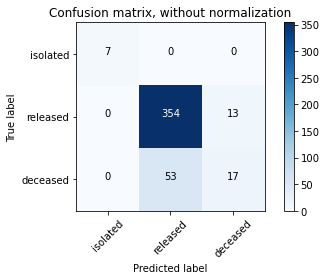

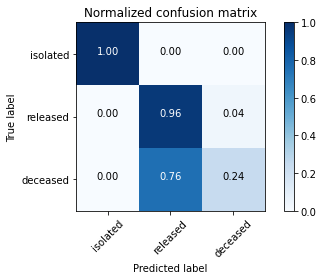

In [125]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

12


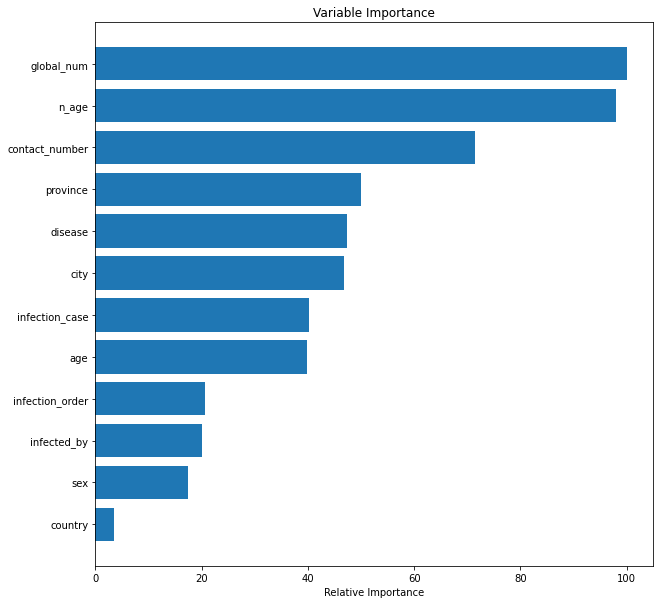

In [126]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [127]:
from pprint import pprint
# Look at parameters used by our current random forest

print('Parameters currently in use:\n')
pprint(model_res.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


The default values for the above parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

The features are always randomly permuted at each split. Therefore, the best split may vary, even with the same training data, max_features=n_features and bootstrap=False, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed.

[More information here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [here](https://scikit-learn.org/stable/modules/ensemble.html#forest)

### Compare Random Forests (Base vs Tuned)

In [129]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [130]:
# Create a based model
clf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

X_train_scaled

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)
grid_search.best_params_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

In [131]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Random Forest (Base) Accuracy= {:.3f}".format(ac * 100), '%')
print("==========================================")
print("Random Forest (Base) f1_score= {:.3f}".format(f1 * 100), '%')

Random Forest (Base) Accuracy= 85.135 %
Random Forest (Base) f1_score= 82.546 %


In [132]:
from sklearn.ensemble import RandomForestClassifier
clf_tuned = RandomForestClassifier(random_state = 1,n_jobs=-1,
                            bootstrap=True, max_depth=110, max_features=3,
                            min_samples_leaf=4, min_samples_split=8, n_estimators=100)
model_tun = clf_tuned.fit(X_train_scaled, y_train)
y_pred_tun = model_tun.predict(X_test_scaled)
y_pred_prob_tun = model_tun.predict_proba(X_test_scaled)
lr_probs_tun = y_pred_prob_tun[:,1]
ac_tun = accuracy_score(y_test, y_pred_tun)

f1_tun = f1_score(y_test, y_pred_tun, average='weighted')
cm_tun = confusion_matrix(y_test, y_pred_tun)

print("Random Forest (Tuned) Accuracy= {:.3f}".format(ac_tun * 100), '%')
print("==========================================")
print("Random Forest (Tuned) f1_score= {:.3f}".format(f1_tun * 100), '%')

Random Forest (Tuned) Accuracy= 86.712 %
Random Forest (Tuned) f1_score= 83.112 %


### Conclusion

- The Random Forests (Base) Model shows an overall accuracy of 85%, which is great and indicates that our model was effectively able to identify the status of the COVID-19 patients in the South Korean dataset despite the fact that we have an imbalanced class "State", due to the nature of the dataset and the topic we're trying to tackle today which is Predicting COVID-19 Patients State , as shown below:


| Code | State | Count |
| :- | -: | :-: |
| 1 | Isolated | 1878
| 2 | Released | 306
| 0 | Deceased | 34


- As shown above, after we fined tuned the Random Forest Parameters, we managed to improve the accuracy by 1.7% from 85% to 86.7% and there was a clear reduction in the Decision Trees size thus reducing memory consumption, the complexity and we find the split choices that will get us to the pure nodes much faster resulting in more information gain (more prediction power)


- The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this project we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other. Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.

